### Building a Text Classification model using BiLSTM

### Data Prepatation

In [65]:
import pandas as pd
url = 'olid-training-v1.0.tsv'
df = pd.read_csv(url, sep="\t")
df.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


In [66]:
del df['subtask_b']
del df['subtask_c']
del df['id']
df.columns = ['tweet', 'label']
df.head()

,tweet,label
0,@USER She should ask a few native Americans wh...,OFF
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF
2,Amazon is investigating Chinese employees who ...,NOT
3,"@USER Someone should'veTaken"" this piece of sh...",OFF
4,@USER @USER Obama wanted liberals &amp; illega...,NOT


In [76]:
#importing required libraries

import nltk
import inflect
import contractions
from bs4 import BeautifulSoup
import re, string, unicodedata
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder

In [68]:
# main denoising function
def denoise_text(text):
    # Strip html if any.
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    # Replace contractions in string of text. For ex. didn't -> did not
    text = contractions.fix(text)
    return text

In [69]:
sample_text = "<p>he didn't say anything </br> about what's gonna <html> happen in the climax"
denoise_text(sample_text)

'he did not say anything  about what is going to  happen in the climax'

In [70]:
# Normalization includes many steps.
# Each function below serves a step.

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize_text(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    #words = stem_words(words)
    words = lemmatize_verbs(words)
    return words


In [72]:
# Testing the functions
print("remove_non_ascii results: ", remove_non_ascii(['h', 'ॐ', '©', '1']))
print("to_lowercase results: ", to_lowercase(['HELLO', 'hiDDen', 'wanT', 'GOING']))
print("remove_punctuation results: ", remove_punctuation(['hello!!', 'how?', 'done,']))
print("replace_numbers results: ", replace_numbers(['1', '2', '3']))
print("remove_stopwords results: ", remove_stopwords(['this', 'and', 'amazing']))
print("stem_words results: ", stem_words(['beautiful', 'flying', 'waited']))
print("lemmatize_verbs results: ", lemmatize_verbs(['hidden', 'walking', 'ran']))
print("normalize_text results: ", normalize_text(['hidden', 'in', 'the', 'ALMIRAH', 'he', 'WAited', '2', 'ॐ', 'hours!!']))

remove_non_ascii results:  ['h', '', '', '1']
to_lowercase results:  ['hello', 'hidden', 'want', 'going']
remove_punctuation results:  ['hello', 'how', 'done']
replace_numbers results:  ['one', 'two', 'three']
remove_stopwords results:  ['amazing']
stem_words results:  ['beauty', 'fly', 'wait']
lemmatize_verbs results:  ['hide', 'walk', 'run']
normalize_text results:  ['hide', 'almirah', 'wait', 'two', 'hours']


In [73]:
# Tokenize tweet into words
def tokenize(text):
    return nltk.word_tokenize(text)

# check the function
sample_text = 'he did not say anything  about what is going to  happen'
print("tokenize results :", tokenize(sample_text))

tokenize results : ['he', 'did', 'not', 'say', 'anything', 'about', 'what', 'is', 'going', 'to', 'happen']


In [77]:
def text_prepare(text):
    text = denoise_text(text)
    text = ' '.join([x for x in normalize_text(tokenize(text))])
    return text

df['tweet'] = [text_prepare(x) for x in df['tweet']]
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
df.head()

,tweet,label
0,user ask native americans take,1
1,user user go home drink user maga trump2020 url,1
2,amazon investigate chinese employees sell inte...,0
3,user someone havetaken piece shit volcano,1
4,user user obama want liberals illegals move re...,0


## Model building

In [118]:
from keras.layers import Dropout, Dense, Embedding, LSTM, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils import shuffle
import numpy as np
import pickle
import matplotlib.pyplot as plt
import warnings
import logging
logging.basicConfig(level=logging.INFO)

In [119]:
def prepare_model_input(X_train, X_test,MAX_NB_WORDS=75000,MAX_SEQUENCE_LENGTH=500):
    np.random.seed(7)
    text = np.concatenate((X_train, X_test), axis=0)
    text = np.array(text)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)
    pickle.dump(tokenizer, open('text_tokenizer.pkl', 'wb'))
    # Uncomment above line to save the tokenizer as .pkl file
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Found %s unique tokens.' % len(word_index))
    indices = np.arange(text.shape[0])
    # np.random.shuffle(indices)
    text = text[indices]
    print(text.shape)
    X_train_Glove = text[0:len(X_train), ]
    X_test_Glove = text[len(X_train):, ]
    embeddings_dict = {}
    f = open("glove.6B.50d.txt", encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_dict[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_dict))
    return (X_train_Glove, X_test_Glove, word_index, embeddings_dict)


## Check function
x_train_sample = ["Lorem Ipsum is simply dummy text of the printing and typesetting industry", "It is a long established fact that a reader will be distracted by the readable content of a page when looking at its layout"]
x_test_sample = ["I’m creating a macro and need some text for testing purposes", "I’m designing a document and don’t want to get bogged down in what the text actually says"]
X_train_Glove_s, X_test_Glove_s, word_index_s, embeddings_dict_s = prepare_model_input(x_train_sample, x_test_sample, 100, 20)
print("\n X_train_Glove_s \n ", X_train_Glove_s)
print("\n X_test_Glove_s \n ", X_test_Glove_s)
print("\n Word index of the word testing is : ", word_index_s["testing"])
print("\n Embedding for thw word want \n \n", embeddings_dict_s["want"])

Found 51 unique tokens.
(4, 20)
Total 400000 word vectors.

 X_train_Glove_s 
  [[ 0  0  0  0  0  0  0  0  8  9  5 10 11  2  6  3 12  4 13 14]
 [17 18 19  1 20 21 22 23 24  3 25 26  6  1 27 28 29 30 31 32]]

 X_test_Glove_s 
  [[ 0  0  0  0  0  0  0  0  0  7 33  1 34  4 35 36  2 37 38 39]
 [ 0  0  0  7 40  1 41  4 42 43 44 45 46 47 48 49  3  2 50 51]]

 Word index of the word testing is :  38

 Embedding for thw word want 
 
 [ 0.13627  -0.054478  0.3703   -0.41574   0.60568  -0.42729  -0.50151
  0.35923  -0.49154   0.21827  -0.15193   0.52536  -0.24206   0.023875
  0.8225    1.089     0.98825  -0.17803   0.77806  -1.0647   -0.28742
  0.50458   0.21612   0.65681   0.34295  -2.1084   -0.82557  -0.31966
  0.87567  -1.0679    3.3802    1.2084   -1.272    -0.15921  -0.25237
 -0.2696   -0.18756  -0.35523   0.084172 -0.56539  -0.24081   0.15926
  0.3287    0.54591   0.29897   0.18948  -0.57113   0.17399  -0.19338
  0.51921 ]


In [120]:
def build_bilstm(word_index, embeddings_dict, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5, hidden_layer = 3, lstm_node = 32):
    # Initialize a sequebtial model
    model = Sequential()
    # Make the embedding matrix using the embedding_dict
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
            
    # Add embedding layer
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    # Add hidden layers 
    for i in range(0,hidden_layer):
        # Add a bidirectional lstm layer
        model.add(Bidirectional(LSTM(lstm_node, return_sequences=True, recurrent_dropout=0.2)))
        # Add a dropout layer after each lstm layer
        model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(lstm_node, recurrent_dropout=0.2)))
    model.add(Dropout(dropout))
    # Add the fully connected layer with 256 nurons and relu activation
    model.add(Dense(256, activation='relu'))
    # Add the output layer with softmax activation since we have 2 classes
    model.add(Dense(nclasses, activation='softmax'))
    # Compile the model using sparse_categorical_crossentropy
    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    return model

In [121]:
X = df.tweet
y = df.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print("Preparing model input ...")
X_train_Glove, X_test_Glove, word_index, embeddings_dict = prepare_model_input(X_train,X_test)
print("Done!")
print("Building Model!")
model = build_bilstm(word_index, embeddings_dict, 2)
model.summary()

Preparing model input ...
Found 16527 unique tokens.
(13240, 500)
Total 400000 word vectors.
Done!
Building Model!
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 50)           826400    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 500, 64)           21248     
_________________________________________________________________
dropout_9 (Dropout)          (None, 500, 64)           0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 500, 64)           24832     
_________________________________________________________________
dropout_10 (Dropout)         (None, 500, 64)           0         
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 500, 64)           24832     
_____

### Training and Evaluatrion

In [114]:
def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    f1 = (2*(precision*recall))/(precision+recall)
    return {
        "mcc": mcc,
        "true positive": tp,
        "true negative": tn,
        "false positive": fp,
        "false negative": fn,
        "pricision" : precision,
        "recall" : recall,
        "F1" : f1,
        "accuracy": (tp+tn)/(tp+tn+fp+fn)
    }

def compute_metrics(labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()


In [108]:
history = model.fit(X_train_Glove, y_train,
                              validation_data=(X_test_Glove, y_test),
                              epochs=5,
                              batch_size=128,
                              verbose=1)

Train on 10592 samples, validate on 2648 samples
Epoch 1/5
10592/10592 [==============================] - 366s 35ms/step - loss: 0.6152 - accuracy: 0.6726 - val_loss: 0.5462 - val_accuracy: 0.7232
Epoch 2/5
10592/10592 [==============================] - 303s 29ms/step - loss: 0.5199 - accuracy: 0.7545 - val_loss: 0.5219 - val_accuracy: 0.7390
Epoch 3/5
10592/10592 [==============================] - 303s 29ms/step - loss: 0.4748 - accuracy: 0.7857 - val_loss: 0.5073 - val_accuracy: 0.7406
Epoch 4/5
10592/10592 [==============================] - 305s 29ms/step - loss: 0.4314 - accuracy: 0.8152 - val_loss: 0.5092 - val_accuracy: 0.7538
Epoch 5/5
10592/10592 [==============================] - 318s 30ms/step - loss: 0.3883 - accuracy: 0.8360 - val_loss: 0.5152 - val_accuracy: 0.7496


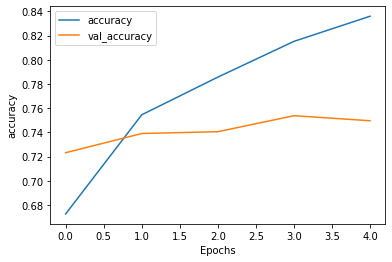

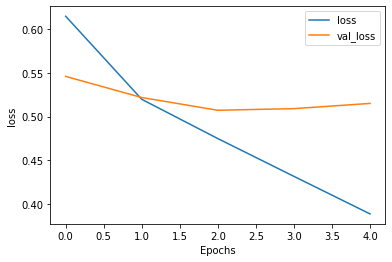

In [111]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [117]:
print("\n Evaluating Model ... \n")
predicted = model.predict_classes(X_test_Glove)
print(metrics.classification_report(y_test, predicted))
print("\n")
logger = logging.getLogger("logger")
result = compute_metrics(y_test, predicted)
for key in (result.keys()):
    logger.info("  %s = %s", key, str(result[key]))


 Evaluating Model ... 



INFO:logger:  mcc = 0.4315456270816665
INFO:logger:  true positive = 533
INFO:logger:  true negative = 1452
INFO:logger:  false positive = 361
INFO:logger:  false negative = 302
INFO:logger:  pricision = 0.5961968680089486
INFO:logger:  recall = 0.6383233532934132
INFO:logger:  F1 = 0.6165413533834587
INFO:logger:  accuracy = 0.7496223564954683


              precision    recall  f1-score   support

           0       0.83      0.80      0.81      1813
           1       0.60      0.64      0.62       835

    accuracy                           0.75      2648
   macro avg       0.71      0.72      0.72      2648
weighted avg       0.75      0.75      0.75      2648





In [ ]:
#To save the tokenizer follow instructions in prepare_model_input function i.e. uncomment this line #pickle.dump(tokenizer, open('text_tokenizer.pkl', 'wb')) in that function

# To save the model run this line
pickle.dump(model_RNN, open('model.pkl', 'wb'))